In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [5]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../train.csv' # TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

## Do your thing crazy machine learning thing here :) ...

## Implement ML functions

In [6]:
def compute_cost(y, tx, w):
    return compute_cost_MSE(y,tx,w)
    
def compute_cost_MSE(y,tx,w):
    e=y-(tx @ w)
    return (1/(2*y.shape[0]))*(e.T @ e)
def compute_cost_MAE(y,tx,w):
    e=y-(tx @ w)
    return (1/y.shape[0])*np.absolute(e).sum()

In [7]:
def compute_gradient_MSE(y,tx,w):
    """Compute the gradient."""
    e=y-(tx @ w)
    return -1/y.shape[0]*(tx.T @ e)

In [8]:
def general_gradient_descent(y, tx, initial_w, max_iters, gamma, grad_function, cost_function):
    """Gradient descent algorithm who work with arbitrary gradient and cost function
    grad and cost function should take y,tw and w as parameter and return resêctivly the gradient vector and the scalar error"""
    # Define parameters to store w and loss
    ws = [initial_w.ravel()]
    losses = []
    w = initial_w.ravel()
    for n_iter in range(max_iters):
        #compute gradient and loss
        gradient=grad_function(y,tx,w)
        loss=cost_function(y,tx,w)
        if n_iter % 1 == 0:
            print("Current iteration={i}, the loss={l}".format(i=n_iter, l=loss))
        #update w by gradient
        w=w-gamma*gradient
        
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        #print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
        #     bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses[-1], ws[-1]

In [9]:
def general_stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma, stock_grad_function, cost_function):
    """Gradient descent algorithm who work with arbitrary gradient and cost function
    grad and cost function should take y,tw and w as parameter and return respectivly the gradient vector and the scalar error"""
    
    # implement stochastic gradient descent.
    ws = [initial_w.ravel()]
    losses = []
    w = initial_w.ravel()
    
    minibatchs = batch_iter(y, tx, batch_size, num_batches=math.floor(y.shape[0]/batch_size))
    for n_iter in range(0,max_epochs):
        
        # compute gradient and loss
        minibatch=minibatchs.__next__()
        gradient=stock_grad_function(minibatch[0],minibatch[1],w)
        loss=cost_function(y,tx,w)
        
        # update w by gradient
        w=w-gamma*gradient
        # store w and loss
        ws.append(np.copy(w))
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses[-1], ws[-1]

In [10]:
def least_squares_GD(y, tx, gamma, max_iters):
    return general_gradient_descent(y,tx,np.zeros((tx.shape[1], 1)).ravel(),max_iters,gamma,compute_gradient_MSE,compute_cost_MSE)

#general_gradient_descent(y,tX,np.zeros((tX.shape[1], 1)),20,0.000003,compute_gradient_MSE,compute_cost_MSE)


In [11]:
def least_squares_SGD(y, tx, gamma, max_iters):
    batch_size = y.shape[0]//2
    return general_stochastic_gradient_descent(y,tx,np.zeros((tx.shape[1], 1)),batch_size,max_iters,gamma,compute_gradient_MSE,compute_cost_MSE)

In [12]:
def least_squares(y, tx):
    w = np.linalg.solve(tx.T.dot(tx),tx.T.dot(y)) #return best weight
    return compute_cost_MSE(y, tx, w), w

In [13]:
def ridge_regression(y, tx, lamb):
    """implement ridge regression."""
    
    lambp = lamb*(2*tx.shape[0])
    #return np.linalg.inv(tx.T.dot(tx)+lambp*np.eye(tx.shape[1])).dot(tx.T).dot(y)
    w =  np.linalg.solve(tx.T.dot(tx)+lambp*np.eye(tx.shape[1]),tx.T.dot(y))
    return compute_cost_MSE(y, tx, w), w

### Logistic

In [14]:
def sigmoid(t):
    """apply sigmoid function on t."""
    z = np.exp(t)
    return z/(1+z)

def compute_loss_logistic(y, tx, w, lambda_ = 0):
    """compute the cost by negative log likelihood."""
    clip = np.clip(tX @ w, -700, 700)
    if lambda_ == 0:
        return (1/w.shape[0])*np.sum(np.log(1+np.exp(clip))-y*(tx @ w))
    else:
        return (1/w.shape[0])*np.sum(np.log(1+np.exp(clip))-y*(tx @ w)) + lambda_*np.sum(w*w) #or + lambda_*w.T*w
    #return -np.sum(np.log(1+np.exp(tx @ w))-y*(tx @ w))
    
def compute_gradient_sigmoid(y, tx, w, lambda_ = 0):
    """compute the gradient of loss."""
    clip = np.clip(tX @ w, -700, 700)
    if lambda_ == 0:
        return tx.T.dot(sigmoid(clip)-y)
    else:
        return tx.T.dot(sigmoid(clip)-y) + lambda_*2*w

In [15]:
def logistic_regression(y, tx, gamma ,max_iters):
    print("fuck")
    ok = general_gradient_descent(y,tx,np.zeros((tx.shape[1], 1)),max_iters,gamma,compute_gradient_sigmoid,compute_loss_logistic)
    return ok

In [16]:
def reg_logistic_regression(y, tx, lambda_ , gamma, max_iters):
    gradf = partial(compute_gradient_sigmoid,lambda_ = lambda_)
    costf = partial(compute_loss_logistic, lambda_ = lambda_)
    return general_gradient_descent(y,tx,np.zeros((tx.shape[1], 1)),max_iters,gamma,gradf,costf)

### Cross-validation

In [17]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]
    return np.array(k_indices)

def cross_validation(y, tx, function_to_test,k_fold, lambda_,seed):
    """return the loss of train values, loss of test values and weights"""
    k_indices=build_k_indices(y,k_fold,seed)
    loss_tr=[]
    loss_te=[]
    weights=[]
    for k in range(k_indices.shape[0]):
        # get k'th subgroup in test, others in train:
        train_indices=k_indices[[i for i in range(len(k_indices)) if i != k]]
        train_tx,train_y=tx[np.ravel(train_indices)],y[np.ravel(train_indices)]
        test_tx,test_y=tx[k_indices[k]],y[k_indices[k]]

        loss_tr_k, weight_k = function_to_test(y, tx,lambda_)
        loss_tr.append(loss_tr_k)
        weights.append(weight_k)
        loss_te.append(compute_cost(test_y,test_tx,weight_k))
    return np.mean(loss_tr), np.mean(loss_te),np.mean(weights,axis=0)

def finding_lambda(y, tx, function_to_test,k_fold,seed,lambdas):
    
    # define lists to store the loss of training data and test data
    loss_tr = []
    loss_te = []
    for lambda_ in lambdas:
        loss_tr_lamb,loss_te_lamb,weight_lamb=cross_validation(y,tx,function_to_test,k_fold,lambda_,seed)
        loss_tr.append(loss_tr_lamb)
        loss_te.append(loss_te_lamb)
    return loss_tr,loss_te
        

	
	



## Prediction Formula

#### Finding a good lambda for ridge regression

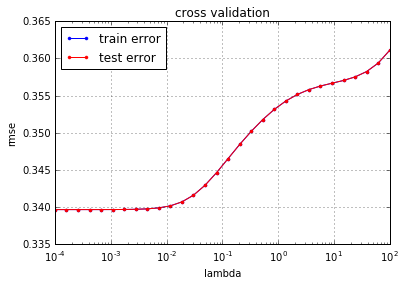

In [37]:
initial_w=np.zeros(tX.shape[1])
function_to_test=ridge_regression
k_fold=4
lambdas = np.logspace(-4, 2, 30)
loss_tr,loss_te=finding_lambda(y,tX,function_to_test,k_fold,1,lambdas)
from helpers import *
cross_validation_visualization(lambdas, loss_tr, loss_te)

In [45]:
loss_tr,loss_te,w=cross_validation(y, tX, ridge_regression,4, 0,1)
loss_tr,loss_te,w

(0.33968680947708496,
 0.33968680947708502,
 array([  8.03494315e-05,  -7.20202273e-03,  -6.05417273e-03,
         -5.47559066e-04,  -1.93874702e-02,   4.73451621e-04,
         -2.60379054e-02,   3.25106300e-01,  -3.80780260e-05,
         -2.72729930e+00,  -2.21220140e-01,   9.50794092e-02,
          6.40351616e-02,   2.73555898e+00,  -3.31801229e-04,
         -9.54325120e-04,   2.74031573e+00,  -5.34164922e-04,
          9.73498609e-04,   3.69225052e-03,   3.54487428e-04,
         -5.43344599e-04,  -3.30448035e-01,  -1.40800497e-03,
          8.31432882e-04,   1.02117272e-03,  -1.68047416e-03,
         -5.83664815e-03,  -1.11087997e-02,   2.72775924e+00]))

#### Finding a good lambda for penalized logistic regression

Current iteration=0, the loss=173286.79513998624
Current iteration=1, the loss=-2725323.6361538046
Current iteration=2, the loss=-3971997.849231036
Current iteration=3, the loss=-5216589.725502743
Current iteration=4, the loss=-6459791.385456852
Current iteration=5, the loss=-7702040.284123338
Current iteration=6, the loss=-8943607.951260855
Current iteration=7, the loss=-10184668.000161018
Current iteration=8, the loss=-11425336.560481435
Current iteration=9, the loss=-12665694.868687969
Current iteration=10, the loss=-13905802.001532283
Current iteration=11, the loss=-15145702.310698617
Current iteration=12, the loss=-16385429.957666349
Current iteration=13, the loss=-17625011.804494277
Current iteration=14, the loss=-18864469.3329265
Current iteration=15, the loss=-20103819.96455706
Current iteration=16, the loss=-21343077.996921953
Current iteration=17, the loss=-22582255.284397073
Current iteration=18, the loss=-23821361.74418858
Current iteration=19, the loss=-25060405.739201825


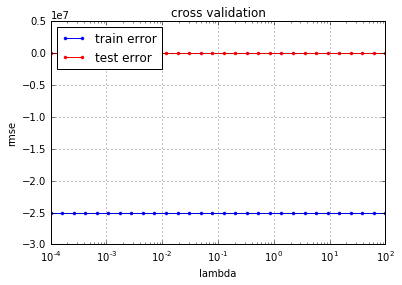

In [40]:
initial_w=np.zeros(tX.shape[1])
gamma=0.00000000003
max_iters=20
function_to_test=partial(reg_logistic_regression,gamma=gamma, max_iters=max_iters)
k_fold=4
lambdas = np.logspace(-4, 2, 30)
loss_tr,loss_te=finding_lambda(y,tX,function_to_test,k_fold,1,lambdas)
from helpers import *
cross_validation_visualization(lambdas, loss_tr, loss_te)

In [46]:
function_to_test=partial(reg_logistic_regression,gamma=0.00000000003, max_iters=20)
loss_tr,loss_te,w=cross_validation(y, tX, function_to_test,4, 0,1)

Current iteration=0, the loss=173286.79513998624
Current iteration=1, the loss=-2725323.636153823
Current iteration=2, the loss=-3971997.8492310923
Current iteration=3, the loss=-5216589.725502851
Current iteration=4, the loss=-6459791.385457025
Current iteration=5, the loss=-7702040.284123588
Current iteration=6, the loss=-8943607.951261204
Current iteration=7, the loss=-10184668.000161486
Current iteration=8, the loss=-11425336.560482025
Current iteration=9, the loss=-12665694.868688699
Current iteration=10, the loss=-13905802.001533171
Current iteration=11, the loss=-15145702.310699677
Current iteration=12, the loss=-16385429.957667593
Current iteration=13, the loss=-17625011.804495722
Current iteration=14, the loss=-18864469.332928155
Current iteration=15, the loss=-20103819.964558944
Current iteration=16, the loss=-21343077.996924095
Current iteration=17, the loss=-22582255.28439947
Current iteration=18, the loss=-23821361.744191248
Current iteration=19, the loss=-25060405.7392047

In [47]:
loss_tr,loss_te,w

(-25060405.739204779,
 46647.696284738129,
 array([  1.33694357e-02,  -5.23693968e-03,  -6.38496017e-03,
         -4.21090844e-03,   4.51753197e-02,   3.50421223e-02,
          4.52580820e-02,  -1.76231905e-04,  -1.73049800e-03,
         -1.33786485e-02,  -1.36878261e-04,   3.45699250e-05,
          4.52355522e-02,  -2.46145734e-03,   4.61850862e-07,
         -5.96181079e-07,  -3.88380111e-03,   1.36589418e-06,
         -2.18141750e-06,  -3.55094573e-03,   2.38980143e-06,
         -1.73906945e-02,  -9.43846803e-05,   2.66331496e-02,
          3.08253214e-02,   3.08255961e-02,   4.32176704e-02,
          4.52486478e-02,   4.52476973e-02,  -7.03338996e-03]))

In [18]:
w=np.zeros((tX.shape[1], 1))#.ravel()
#ok = general_gradient_descent(y,tX,w,50,0.00000000003,compute_gradient_sigmoid,compute_loss_logistic)
ok2 = logistic_regression(y,tX,0.00000000003,20)

fuck
Current iteration=0, the loss=173286.79513998624
Current iteration=1, the loss=-2725323.636153823
Current iteration=2, the loss=-3971997.8492310923
Current iteration=3, the loss=-5216589.725502851
Current iteration=4, the loss=-6459791.385457025
Current iteration=5, the loss=-7702040.284123588
Current iteration=6, the loss=-8943607.951261204
Current iteration=7, the loss=-10184668.000161486
Current iteration=8, the loss=-11425336.560482025
Current iteration=9, the loss=-12665694.868688699
Current iteration=10, the loss=-13905802.001533171
Current iteration=11, the loss=-15145702.310699677
Current iteration=12, the loss=-16385429.957667593
Current iteration=13, the loss=-17625011.804495722
Current iteration=14, the loss=-18864469.332928155
Current iteration=15, the loss=-20103819.964558944
Current iteration=16, the loss=-21343077.996924095
Current iteration=17, the loss=-22582255.28439947
Current iteration=18, the loss=-23821361.744191248
Current iteration=19, the loss=-25060405.73

In [19]:
w=np.zeros((tX.shape[1], 1)).ravel()
y2 = y.copy()
y2[np.where(y==-1)] = 0
test = np.clip(tX @ w, -700, 700)
zbub = compute_loss_logistic(y2,tX,w,0.03)
zbub2 = compute_gradient_sigmoid(y2,tX,w,0.03)
tX2 = tX.copy()
tX2[np.where(tX2==-999)] = 0
e=y-(tX @ w)
print(np.log(1+np.exp(test))-y*(tX @ w))
#ok = general_gradient_descent(y2,tX2,w,50,0.00000000003,compute_gradient_sigmoid,compute_loss_logistic)
ok = least_squares_GD(y2,tX2,0.00000000003,20)
#ok = general_gradient_descent(y2,tX,w,20,0.0000003,compute_gradient_MSE,compute_cost_MSE)
#ok = general_gradient_descent(y2,tX,w,10,-0.003,compute_gradient_MSE,compute_cost_MSE)
#print((tX @ w).shape,zbub,zbub2,ok)
#print(txs.shape,y.shape[1])
#compute_loss_logistic(y,test,w)

#a = compute_loss_logistic(y,tX,w)
#print(txs,sigmoid(-700))

[ 0.69314718  0.69314718  0.69314718 ...,  0.69314718  0.69314718
  0.69314718]
Current iteration=0, the loss=0.171334
Current iteration=1, the loss=0.1713333932443948
Current iteration=2, the loss=0.17133278649535727
Current iteration=3, the loss=0.17133217975288226
Current iteration=4, the loss=0.1713315730169729
Current iteration=5, the loss=0.17133096628762776
Current iteration=6, the loss=0.17133035956484663
Current iteration=7, the loss=0.17132975284863
Current iteration=8, the loss=0.17132914613897757
Current iteration=9, the loss=0.17132853943588938
Current iteration=10, the loss=0.1713279327393654
Current iteration=11, the loss=0.17132732604940526
Current iteration=12, the loss=0.17132671936600968
Current iteration=13, the loss=0.1713261126891773
Current iteration=14, the loss=0.1713255060189094
Current iteration=15, the loss=0.171324899355205
Current iteration=16, the loss=0.1713242926980641
Current iteration=17, the loss=0.17132368604748757
Current iteration=18, the loss=0.1

In [20]:
# _ ,weights = least_squares(y,tX)
losss,weights = least_squares(y,tX)

In [21]:
print(losss,weights)

0.339686809477 [  8.03494315e-05  -7.20202273e-03  -6.05417273e-03  -5.47559066e-04
  -1.93874702e-02   4.73451621e-04  -2.60379054e-02   3.25106300e-01
  -3.80780260e-05  -2.72729930e+00  -2.21220140e-01   9.50794092e-02
   6.40351616e-02   2.73555898e+00  -3.31801229e-04  -9.54325120e-04
   2.74031573e+00  -5.34164922e-04   9.73498609e-04   3.69225052e-03
   3.54487428e-04  -5.43344599e-04  -3.30448035e-01  -1.40800497e-03
   8.31432882e-04   1.02117272e-03  -1.68047416e-03  -5.83664815e-03
  -1.11087997e-02   2.72775924e+00]


## Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../test.csv' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
OUTPUT_PATH = '../submission.csv' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)